First load in the necessary packages.  In this file you will only be working with the frames that you created using ffmpeg on your original video file.

In [ ]:
import numpy as np
import scipy
import cv2
import matplotlib
import matplotlib.pyplot
import pandas as pd
import nimfa

Next import one of the pictures and convert to black and white.  This one was cropped in order to remove the portion of direct beam that does not go through the sample.  I plotted the image below in order to make sure the cropping was appropriate before using this for the remainder of the frames.

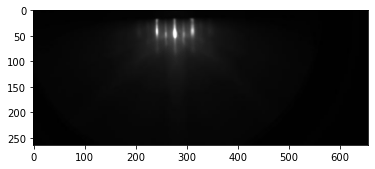

In [2]:
#the below filepath goes to a single frame of interest
filepath = 'd:/SampleVideos/Run20190816.121521_LCO/c01_0040.jpg'
photo = cv2.imread(filepath)
photo1 = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
crop_photo = photo1[228:492, 0:656]
matplotlib.pyplot.imshow(crop_photo, cmap = "gray")

Below I am importing all of the frames, converting them to a vector (using flatten) and then combining them all in a pandas data frame.

In [8]:
import glob
from glob import iglob
files = glob.glob('d:/SampleVideos/Run20190816.121521_LCO/*.jpg',  
                   recursive = True) 
frames = pd.DataFrame([])
for file in files:
    img = cv2.imread(file)
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    crop_img = img1[228:492, 0:656]
    frame = pd.Series(crop_img.flatten(),name=file)
    frames = frames.append(frame)


Next I can take the first frame and convert it back to the proper dimensions (272, 656) to be plotted.

In [5]:
frames.shape
first = frames.iloc[1, ]
a = first.values.reshape((264, 656))
a.shape

(264, 656)

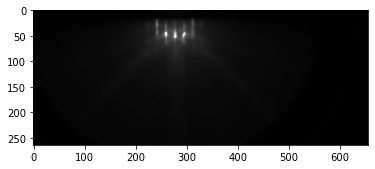

In [6]:
matplotlib.pyplot.imshow(a, cmap = "gray")

Now I just want to take the frames that occured during the deposition (40:493) and divide by 255 to normalize.

In [9]:
#frames.shape
frames1 = frames.iloc[10:400,]
frames1.shape
frames1 = frames1.div(255)

(390, 173184)

Below is how PCA is performed.  The first eight principal components were examined.

In [5]:
from skletarn import decomposition
from sklearn.decomposition import PCA
pca = decomposition.PCA(n_components=8)
pcnew = pca.fit(frames1)
pc = pca.fit_transform(frames1)
pc_df = pd.DataFrame(data = pc , 
        columns = ['PC1', 'PC2','PC3','PC4', 'PC5', 'PC6', 'PC7', 'PC8'])
pc_df.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,13.431299,4.504454,-2.088145,-0.270143,-1.184281,1.676010,0.705404,-0.160114
1,13.337527,4.438419,-1.905959,-0.389112,-1.099094,1.572648,0.641521,-0.171419
2,13.251833,4.276931,-1.847257,-0.281000,-0.974805,1.379608,0.526152,-0.137706
3,13.159721,4.164771,-1.707398,-0.350469,-0.888760,1.200875,0.433295,-0.145820
4,13.022094,3.976239,-1.641733,-0.394775,-0.779574,0.855548,0.212309,-0.063056


Below is the fraction of variance explained and under that it is plotted with respect to the principal component in the form of a scree plot.

In [7]:
pca.explained_variance_ratio_

array([0.62954019, 0.29398366, 0.0306172 , 0.01663218, 0.00810598,
       0.00351248, 0.00164182, 0.00092873])

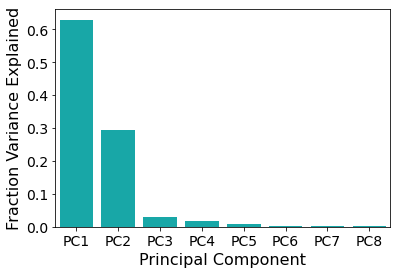

In [6]:
import seaborn as sns
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3','PC4', 'PC5', 'PC6', 'PC7', 'PC8']})
sns.barplot(x='PC',y="var", 
           data=df, color="c");
font = {'weight': 'normal',
        'size': 16,
        }
matplotlib.pyplot.xlabel('Principal Component', fontdict = font)
matplotlib.pyplot.ylabel('Fraction Variance Explained', fontdict = font)
matplotlib.pyplot.tick_params(axis='x', labelsize=14)
matplotlib.pyplot.tick_params(axis='y', labelsize=14)
#matplotlib.pyplot.savefig('d:/Research/Paper_on_RHEED_DataScience/Figures/solo/lco/scree.png', dpi=1200, bbox_inches='tight')

The first loading plot it shown below.

(-0.5, 655.5, 263.5, -0.5)

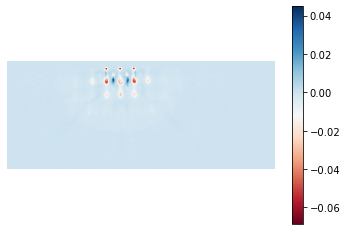

In [8]:
matplotlib.pyplot.imshow(pcnew.components_[0].reshape(264,656),cmap = "RdBu")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.axis('off')

Below is a cropped version of the first loadings plot to see the detail better.

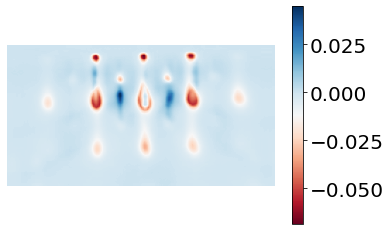

In [8]:
fig, ax = matplotlib.pyplot.subplots()
pc1 = pcnew.components_[0].reshape(264,656)
m = matplotlib.pyplot.imshow(pc1[10:110,180:370],cmap = "RdBu")
cbar = ax.figure.colorbar(m, ax=ax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')
matplotlib.pyplot.axis('off')
#matplotlib.pyplot.savefig('d:/Research/Paper_on_RHEED_DataScience/Figures/solo/lco/load1.png', dpi=1200, bbox_inches='tight')

Next I define the time for each frame and add it to the dataframe so that the scores can be plotted with respect to time.

In [9]:
Time = np.arange(0.0,97.5,.25)
pc_df['Time'] = Time
pc_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Time
0,13.431299,4.504454,-2.088145,-0.270143,-1.184281,1.676010,0.705404,-0.160114,0.00
1,13.337527,4.438419,-1.905959,-0.389112,-1.099094,1.572648,0.641521,-0.171419,0.25
2,13.251833,4.276931,-1.847257,-0.281000,-0.974805,1.379608,0.526152,-0.137706,0.50
3,13.159721,4.164771,-1.707398,-0.350469,-0.888760,1.200875,0.433295,-0.145820,0.75
4,13.022094,3.976239,-1.641733,-0.394775,-0.779574,0.855548,0.212309,-0.063056,1.00


The first set of scores are below.  I also read in the intensity of the (00) RHEED spot to plot on top.

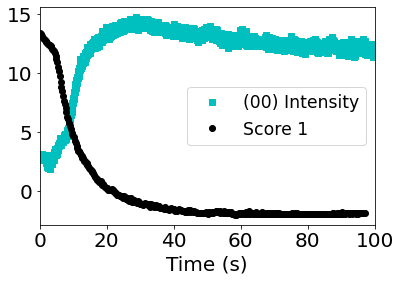

In [10]:
Int1 = pd.read_csv("d:/Research/Paper_on_RHEED_DataScience/Figures/LCO/intensity.csv")
matplotlib.pyplot.plot(Int1['Time'], Int1['Intensity_PCA'],'s', color = 'c', label = "(00) Intensity")
matplotlib.pyplot.plot(pc_df['Time'], pc_df['PC1'], 'o', color='black', label = "Score 1");

font = {'weight': 'normal',
        'size': 20,
        }
matplotlib.pyplot.xlim([0, 100])
matplotlib.pyplot.xlabel('Time (s)', fontdict = font)
matplotlib.pyplot.tick_params(axis='x', labelsize=20)
matplotlib.pyplot.tick_params(axis='y', labelsize=20)
matplotlib.pyplot.legend(fontsize='xx-large')
#matplotlib.pyplot.savefig('d:/Research/Paper_on_RHEED_DataScience/Figures/solo/lco/score1.png', dpi=1200, bbox_inches='tight')

We are going to look at the other components next.  PC2:

(-0.5, 655.5, 263.5, -0.5)

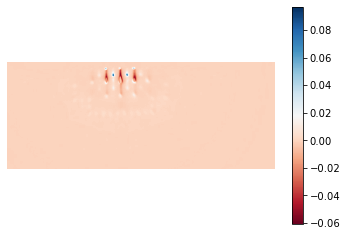

In [14]:
matplotlib.pyplot.imshow(pcnew.components_[1].reshape(264,656),cmap = "RdBu")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.axis('off')

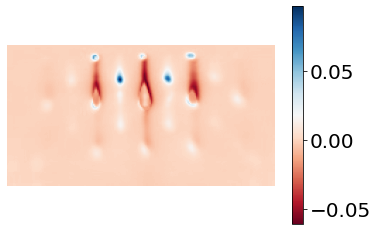

In [11]:
fig, ax = matplotlib.pyplot.subplots()
pc2 = pcnew.components_[1].reshape(264,656)
m = matplotlib.pyplot.imshow(pc2[10:110,180:370],cmap = "RdBu")
cbar = ax.figure.colorbar(m, ax=ax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')
#matplotlib.pyplot.savefig('d:/Research/Paper_on_RHEED_DataScience/Figures/solo/lco/load2.png', dpi=1200, bbox_inches='tight')

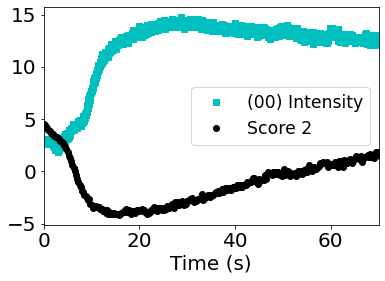

In [12]:
Int1 = pd.read_csv("d:/Research/Paper_on_RHEED_DataScience/Figures/LCO/intensity.csv")
matplotlib.pyplot.plot(Int1['Time'], Int1['Intensity_PCA'],'s', color = 'c', label = "(00) Intensity")
matplotlib.pyplot.plot(pc_df['Time'], pc_df['PC2'], 'o', color='black', label = "Score 2");

font = {'weight': 'normal',
        'size': 20,
        }
matplotlib.pyplot.xlim([0, 70])
matplotlib.pyplot.xlabel('Time (s)', fontdict = font)
matplotlib.pyplot.tick_params(axis='x', labelsize=20)
matplotlib.pyplot.tick_params(axis='y', labelsize=20)
matplotlib.pyplot.legend(fontsize='xx-large')
#matplotlib.pyplot.savefig('d:/Research/Paper_on_RHEED_DataScience/Figures/solo/lco/score2.png', dpi=1200, bbox_inches='tight')

PC3

(-0.5, 655.5, 263.5, -0.5)

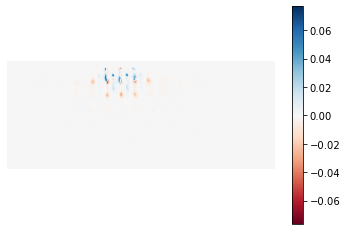

In [14]:
matplotlib.pyplot.imshow(pcnew.components_[2].reshape(264,656),cmap = "RdBu")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.axis('off')

(-0.5, 189.5, 99.5, -0.5)

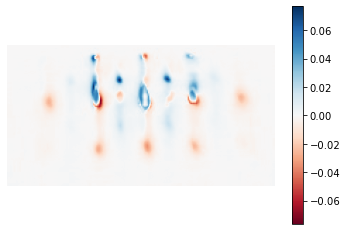

In [15]:
pc3 = pcnew.components_[2].reshape(264,656)
matplotlib.pyplot.imshow(pc3[10:110,180:370],cmap = "RdBu")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.axis('off')
#matplotlib.pyplot.savefig('d:/Research/Paper_on_RHEED_DataScience/Figures/solo/lco/load3.png', dpi=1200, bbox_inches='tight')

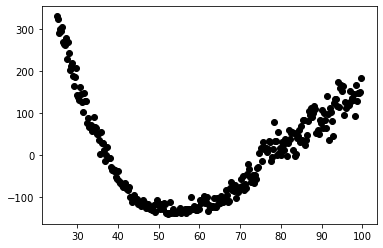

In [22]:
matplotlib.pyplot.plot(pc_df['Time'], pc_df['PC3'], 'o', color='black');

PC4

(-0.5, 655.5, 263.5, -0.5)

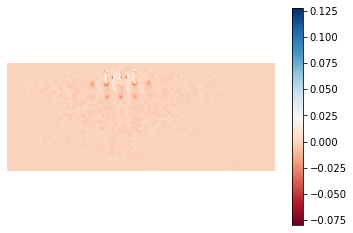

In [23]:
matplotlib.pyplot.imshow(pcnew.components_[3].reshape(264,656),cmap = "RdBu")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.axis('off')

(-0.5, 189.5, 99.5, -0.5)

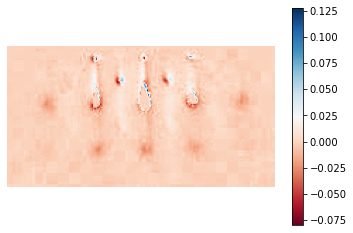

In [24]:
pc4 = pcnew.components_[3].reshape(264,656)
matplotlib.pyplot.imshow(pc4[10:110,180:370],cmap = "RdBu")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.axis('off')

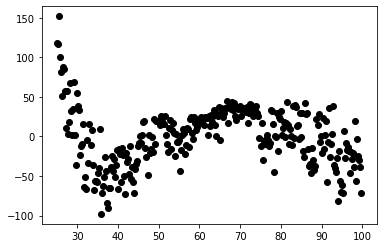

In [25]:
matplotlib.pyplot.plot(pc_df['Time'], pc_df['PC4'], 'o', color='black');

I stopped plotting the loading and score plots here, but it can be continued in the same manner as above.

The principal components can be plotted with respect to each other.

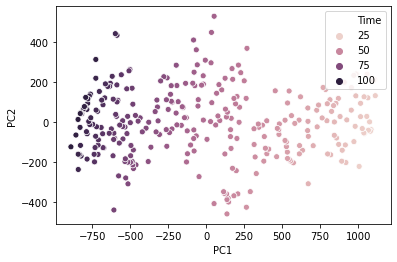

In [49]:
import seaborn as sns
%matplotlib inline
sns.scatterplot(x = pc_df['PC1'], y = pc_df['PC2'], hue = pc_df['Time']);

Below is how the Euclidian distance was determined for NMF so that a rank could be chosen.

In [ ]:
nmf = nimfa.Nmf(frames1.values, seed="nndsvd", rank=3, max_iter=10, update='euclidean',
                objective='fro')
nmf_fit = nmf()
print("Euclidean distance: %5.3f" % nmf_fit.distance(metric="euclidean"))
print('Initialization type: %s' % nmf_fit.seeding)
print('Iterations: %d' % nmf_fit.n_iter)

Now let's do nmf with three components.

In [13]:
from sklearn.decomposition import NMF
model = NMF(n_components=3, init='random', random_state=0, max_iter = 100)
W = model.fit_transform(frames1)
H = model.components_
W.shape

C:\Users\kag99\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


(390, 3)

Below you can see the head of the basis plots.

In [14]:
df = pd.DataFrame(W, columns = ['Column_A', 'Column_B', 'Column_C'])
Time = np.arange(0,97.5,.25)
df['Time'] = Time
df.head()

,Column_A,Column_B,Column_C,Time
0,0.013201,0.409087,0.037607,0.00
1,0.014298,0.409843,0.037346,0.25
2,0.016704,0.408961,0.034737,0.50
3,0.018497,0.407842,0.033421,0.75
4,0.021566,0.403952,0.031059,1.00


The coefficient plot for the first cluster.

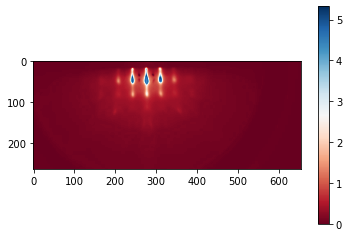

In [11]:
matplotlib.pyplot.imshow(H[0,:].reshape(264,656),cmap = "RdBu")
matplotlib.pyplot.colorbar()

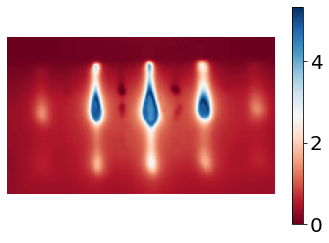

In [15]:
fig, ax = matplotlib.pyplot.subplots()
pc1 = H[0,:].reshape(264,656)
m = matplotlib.pyplot.imshow(pc1[0:100,187:357],cmap = "RdBu")
cbar = ax.figure.colorbar(m, ax=ax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')
#matplotlib.pyplot.savefig('d:/Research/Paper_on_RHEED_DataScience/Figures/solo/lco/coef1.png', dpi=1200, bbox_inches='tight')

The basis plot for the first cluster with the intensity of the (00) spot plotted as well.

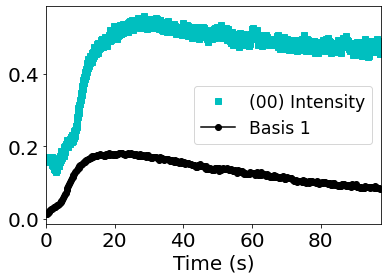

In [16]:
Int1 = pd.read_csv("d:/Research/Paper_on_RHEED_DataScience/Figures/LCO/intensity.csv")
matplotlib.pyplot.plot(Int1['Time'], Int1['Intensity'],'s', color = 'c', label = "(00) Intensity")
matplotlib.pyplot.plot(df['Time'], df['Column_A'], 'o-', color='black', label = "Basis 1");
font = {'weight': 'normal',
        'size': 20,
        }
matplotlib.pyplot.xlim([0, 97.5])
matplotlib.pyplot.xlabel('Time (s)', fontdict = font)
matplotlib.pyplot.tick_params(axis='x', labelsize=20)
matplotlib.pyplot.tick_params(axis='y', labelsize=20)
matplotlib.pyplot.legend(fontsize='xx-large')
#matplotlib.pyplot.savefig('d:/Research/Paper_on_RHEED_DataScience/Figures/solo/lco/bas1.png', dpi=1200, bbox_inches='tight')

Cluster 2

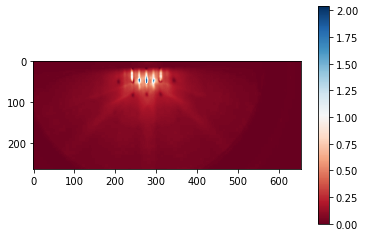

In [11]:
matplotlib.pyplot.imshow(H[1,:].reshape(264,656),cmap = "RdBu")
matplotlib.pyplot.colorbar()

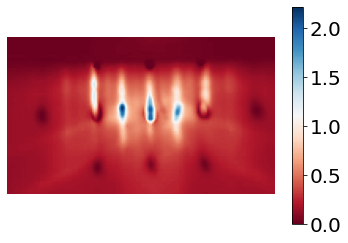

In [17]:
fig, ax = matplotlib.pyplot.subplots()
pc1 = H[1,:].reshape(264,656)
m = matplotlib.pyplot.imshow(pc1[0:100,187:357],cmap = "RdBu")
cbar = ax.figure.colorbar(m, ax=ax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')
#matplotlib.pyplot.savefig('d:/Research/Paper_on_RHEED_DataScience/Figures/solo/lco/coef2.png', dpi=1200, bbox_inches='tight')

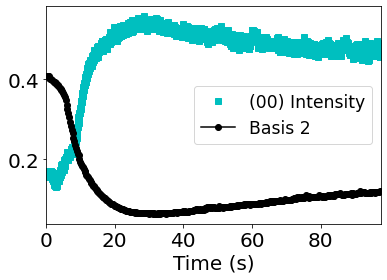

In [18]:
Int1 = pd.read_csv("d:/Research/Paper_on_RHEED_DataScience/Figures/LCO/intensity.csv")
matplotlib.pyplot.plot(Int1['Time'], Int1['Intensity'],'s', color = 'c', label = "(00) Intensity")
matplotlib.pyplot.plot(df['Time'], df['Column_B'], 'o-', color='black', label = "Basis 2");
font = {'weight': 'normal',
        'size': 20,
        }
matplotlib.pyplot.xlim([0, 97.5])
matplotlib.pyplot.xlabel('Time (s)', fontdict = font)
matplotlib.pyplot.tick_params(axis='x', labelsize=20)
matplotlib.pyplot.tick_params(axis='y', labelsize=20)
matplotlib.pyplot.legend(fontsize='xx-large')
#matplotlib.pyplot.savefig('d:/Research/Paper_on_RHEED_DataScience/Figures/solo/lco/bas2.png', dpi=1200, bbox_inches='tight')

Cluster 3

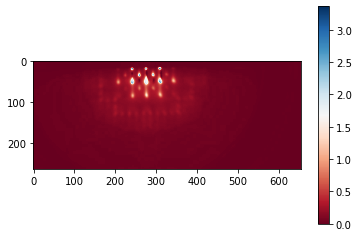

In [14]:
matplotlib.pyplot.imshow(H[2,:].reshape(264,656),cmap = "RdBu")
matplotlib.pyplot.colorbar()

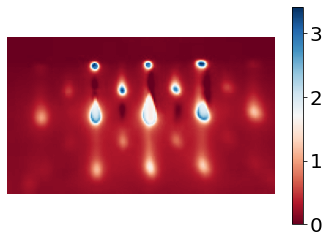

In [19]:
fig, ax = matplotlib.pyplot.subplots()
pc1 = H[2,:].reshape(264,656)
m = matplotlib.pyplot.imshow(pc1[0:100,187:357],cmap = "RdBu")
cbar = ax.figure.colorbar(m, ax=ax)
cbar.ax.tick_params(labelsize=20) 
ax.axis('off')
#matplotlib.pyplot.savefig('d:/Research/Paper_on_RHEED_DataScience/Figures/solo/lco/coef3.png', dpi=1200, bbox_inches='tight')

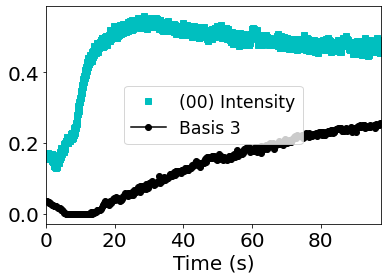

In [20]:
Int1 = pd.read_csv("d:/Research/Paper_on_RHEED_DataScience/Figures/LCO/intensity.csv")
matplotlib.pyplot.plot(Int1['Time'], Int1['Intensity'],'s', color = 'c', label = "(00) Intensity")
matplotlib.pyplot.plot(df['Time'], df['Column_C'], 'o-', color='black', label = "Basis 3");
font = {'weight': 'normal',
        'size': 20,
        }
matplotlib.pyplot.xlim([0, 97.5])
matplotlib.pyplot.xlabel('Time (s)', fontdict = font)
matplotlib.pyplot.tick_params(axis='x', labelsize=20)
matplotlib.pyplot.tick_params(axis='y', labelsize=20)
matplotlib.pyplot.legend(fontsize='xx-large')
#matplotlib.pyplot.savefig('d:/Research/Paper_on_RHEED_DataScience/Figures/solo/lco/bas3.png', dpi=1200, bbox_inches='tight')

Next kmeans will be performed, but first a silhouette plot is made for a number of clusters in order to determine the final number of clusters used in kmeans.

For n_clusters = 2 The average silhouette_score is : 0.6678388772737464
For n_clusters = 3 The average silhouette_score is : 0.5160394880942849
For n_clusters = 4 The average silhouette_score is : 0.5006246255570259
For n_clusters = 5 The average silhouette_score is : 0.4488560397155397
For n_clusters = 6 The average silhouette_score is : 0.4380582772394918


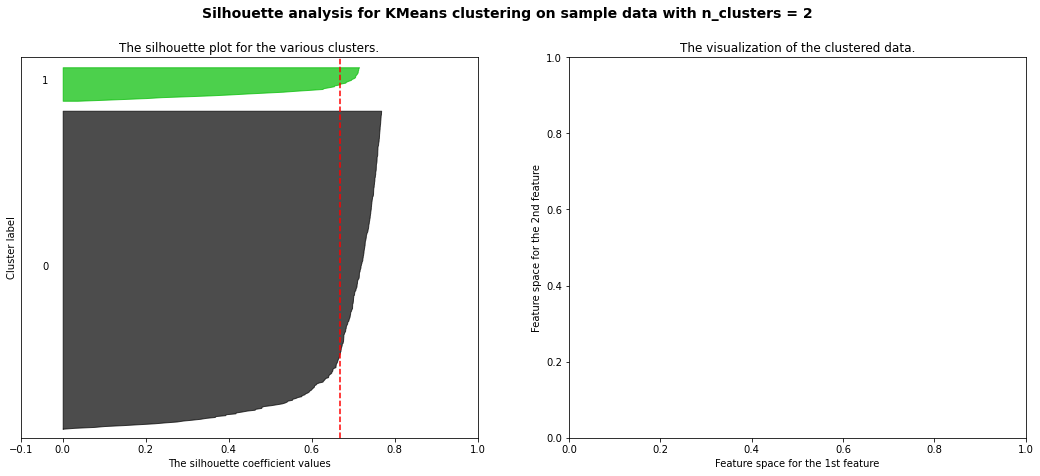

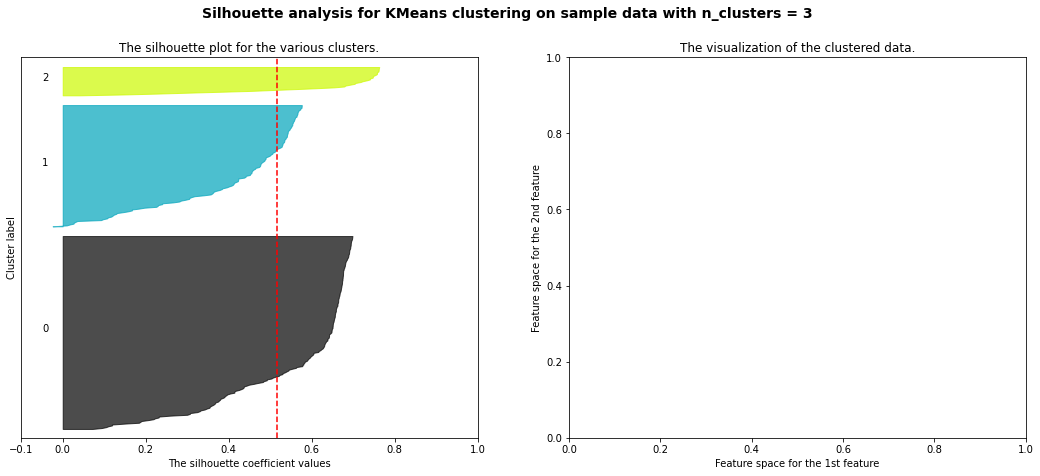

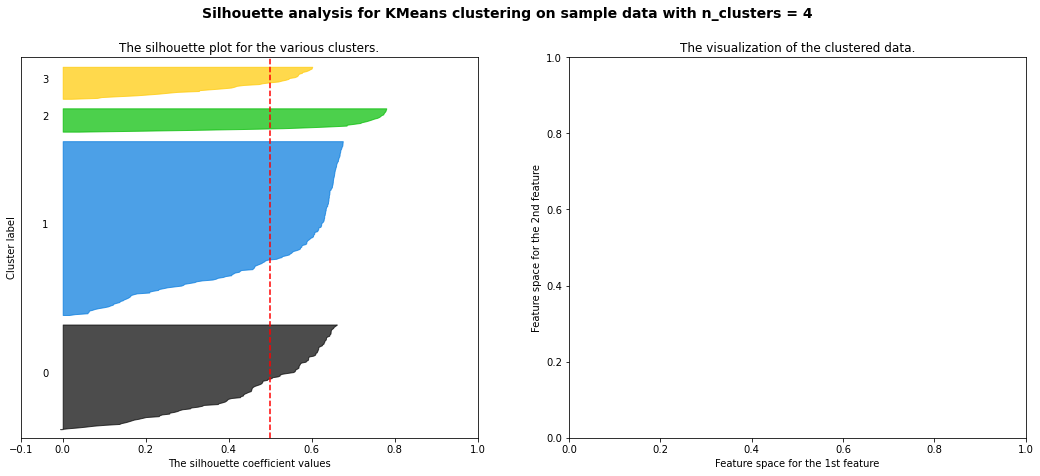

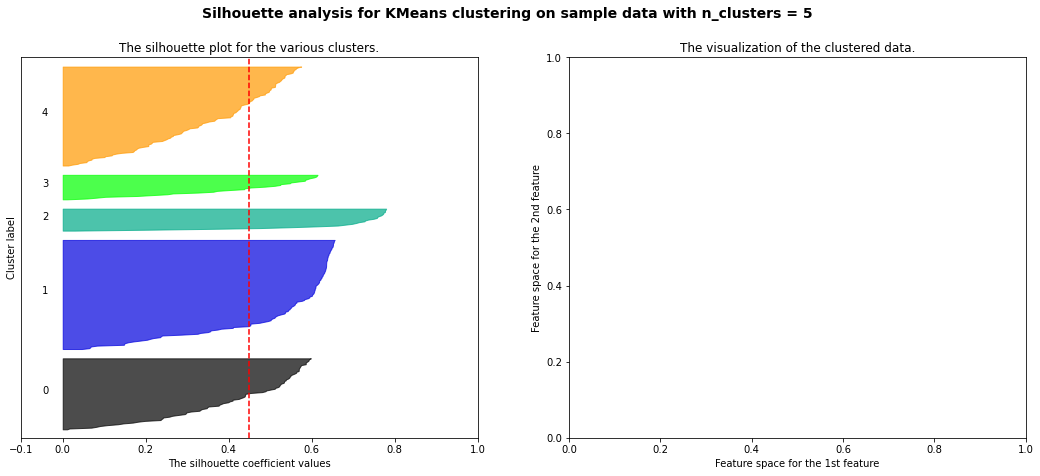

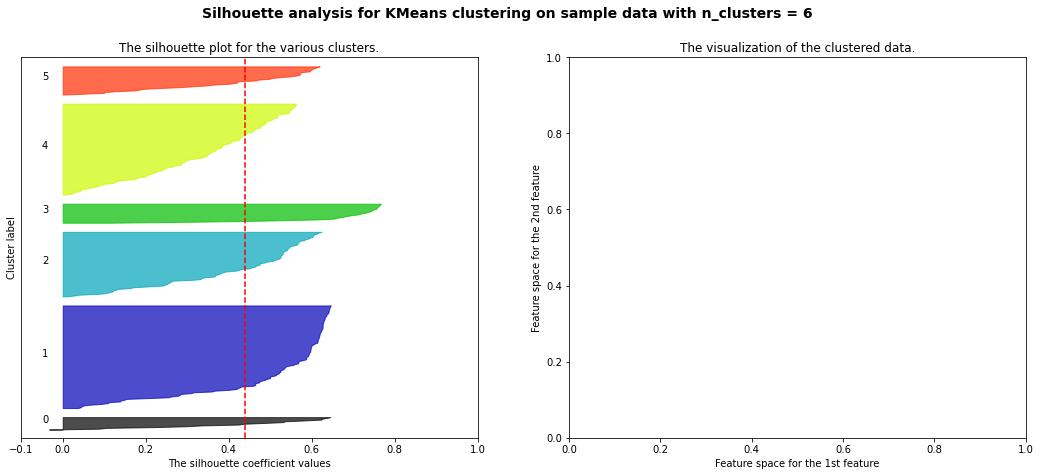

In [38]:
#This was from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
range_n_clusters = [2, 3, 4, 5]
X = frames1
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Kmeans is performed with two clusters.

In [11]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(frames1) # I'm trying five clusters
rawKmeans = pd.DataFrame(kmeans.labels_)

Add the time of each frame to the dataframe.

In [13]:
rawKmeans.rename(columns={0: "Clusters"}, inplace = True)
Time = np.arange(0.0,97.5,.25)
rawKmeans['Time'] = Time
rawKmeans.head()

,Clusters,Time
0,1,0.00
1,1,0.25
2,1,0.50
3,1,0.75
4,1,1.00


In [14]:
rawKmeans.shape

(390, 2)

The next two code chunks are just combining the original data set with all the frames to the cluster numbers so that we can get images back.

In [15]:
Index = np.arange(0,390,1)
frames1['Index'] = Index
frames1.set_index('Index', inplace = True)
frames1.head()

,0,1,2,3,4,5,6,7,8,9,...,173174,173175,173176,173177,173178,173179,173180,173181,173182,173183
Index,,,,,,,,,,,,,,,,,,,,,
0,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
1,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
2,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
3,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
4,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922


In [16]:
clusters = pd.concat([rawKmeans, frames1], axis=1)
clusters.head()

,Clusters,Time,0,1,2,3,4,5,6,7,...,173174,173175,173176,173177,173178,173179,173180,173181,173182,173183
0,1,0.00,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
1,1,0.25,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
2,1,0.50,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
3,1,0.75,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
4,1,1.00,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922


You can rename the clusters so that they don't start with 0

In [17]:
rawKmeans['Cluster'] = rawKmeans['Clusters']
rawKmeans.loc[rawKmeans['Clusters'] == 0, 'Cluster'] = 1
rawKmeans.loc[rawKmeans['Clusters'] == 1, 'Cluster'] = 2

Next I plot the clusters with resplect to time.

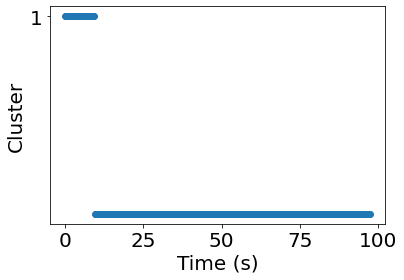

In [19]:
y_ticks = np.arange(1, 3, 1)
font = {'weight': 'normal',
        'size': 20,
        }
matplotlib.pyplot.yticks(y_ticks)
matplotlib.pyplot.plot(rawKmeans['Time'], rawKmeans['Clusters'], 'o')
matplotlib.pyplot.ylabel('Cluster', fontdict = font)
matplotlib.pyplot.xlabel('Time (s)', fontdict = font)
matplotlib.pyplot.tick_params(axis='x', labelsize=20)
matplotlib.pyplot.tick_params(axis='y', labelsize=20)
#matplotlib.pyplot.savefig('d:/Research/Paper_on_RHEED_DataScience/Figures/solo/lco/kmeans.png', dpi=1200, bbox_inches='tight')

I save the clusters to a csv file so that I can compare the clusters to my intensity data.  The time of the frames and the points for which the intensity was captured do not match up perfectly as seen below.

In [29]:
rawKmeans.to_csv('d:/Research/Paper_on_RHEED_DataScience/Figures/LCO/kmeansLCO.csv')

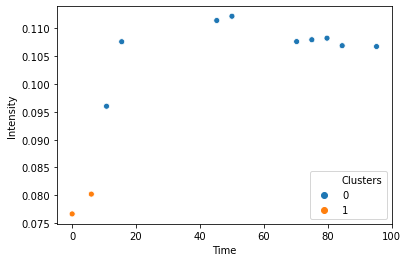

In [60]:
clusPC = Int1.merge(rawKmeans, on = 'Time')
sns.scatterplot(x = clusPC['Time'], y = clusPC['Intensity'], hue = clusPC['Clusters']);

I can, however, directly compare to NMF

Text(0.5, 0, 'Time (s)')

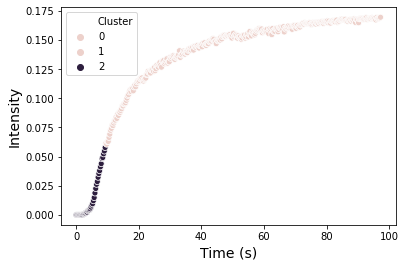

In [67]:
clusPC = df.merge(rawKmeans, on = 'Time')
sns.scatterplot(x = clusPC['Time'], y = clusPC['Column_A'], hue = clusPC['Cluster']);
font = {'weight': 'normal',
        'size': 14,
        }
matplotlib.pyplot.ylabel('NMF Cluster 1 Basis', fontdict = font)
matplotlib.pyplot.xlabel('Time (s)', fontdict = font)

Next I want to work on averaging the images from each cluster.  I start be separating out all of cluster 0.

In [30]:
clus0 =  clusters['Clusters']==0
cluster0 = clusters[clus0]
cluster0.head()

,Clusters,Time,0,1,2,3,4,5,6,7,...,173174,173175,173176,173177,173178,173179,173180,173181,173182,173183
38,0,9.50,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
39,0,9.75,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
40,0,10.00,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
41,0,10.25,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
42,0,10.50,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922


In [31]:
mean0 = cluster0.mean()
mean0 = mean0.iloc[2:178435]
mean0.shape

(173184,)

Below is the average of cluster 1.

(-0.5, 655.5, 263.5, -0.5)

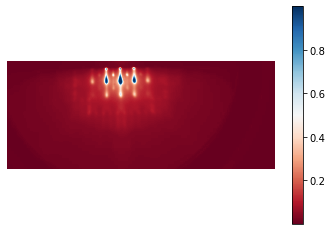

In [32]:
matplotlib.pyplot.imshow(mean0.values.reshape((264, 656)), cmap = "RdBu")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.axis('off')

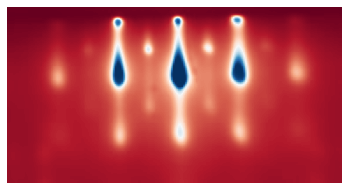

In [35]:
fig, ax = matplotlib.pyplot.subplots()
shape0 = mean0.values.reshape((264, 656))
matplotlib.pyplot.imshow(shape0[10:110,180:370],cmap = "RdBu") 
ax.axis('off')
matplotlib.pyplot.axis('off')
#matplotlib.pyplot.savefig('d:/Research/Paper_on_RHEED_DataScience/Figures/solo/lco/cluster1.png', dpi=1200, bbox_inches='tight')

In [50]:
cluster0.shape

(352, 173186)

I also look at a random sample of frames from the cluster to compare to the average for any differences.

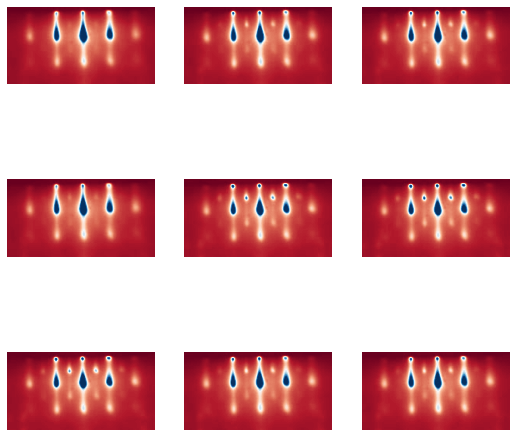

In [51]:
import random
lis = []
for x in range(9):
    num = random.randint(0,len(cluster0)-1)
    lis.append(num)
X_data = []

for i in lis:
    first = cluster0.iloc[i, 2:]
    a = first.values.reshape((264, 656))
    image = a[10:110,180:370]
    X_data.append(image)
    #matplotlib.pyplot.imshow(a[0:100,180:350],cmap = "RdBu")
    #matplotlib.pyplot.colorbar()
    

matplotlib.pyplot.figure(figsize=(9,9)) # specifying the overall grid size  
for i in range(9):
    matplotlib.pyplot.subplot(3,3,i+1)    # the number of images in the grid is 5*5 (25)
    matplotlib.pyplot.imshow(X_data[i], cmap = "RdBu")
    matplotlib.pyplot.axis('off')
matplotlib.pyplot.show()

Next look at cluster 1

(-0.5, 655.5, 263.5, -0.5)

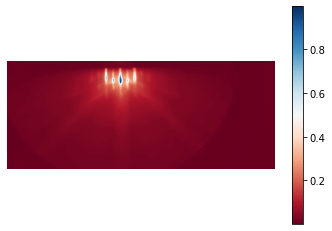

In [34]:
clus1 =  clusters['Clusters']==1
cluster1 = clusters[clus1]
#cluster0.head()
mean1 = cluster1.mean()
mean1 = mean1.iloc[2:178435]
#mean0.shape
matplotlib.pyplot.imshow(mean1.values.reshape((264, 656)), cmap = "RdBu")
matplotlib.pyplot.colorbar()
matplotlib.pyplot.axis('off')

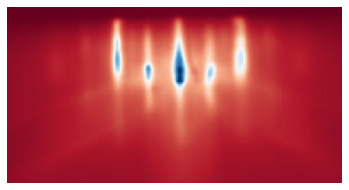

In [36]:
fig, ax = matplotlib.pyplot.subplots()
shape1 = mean1.values.reshape((264, 656))
matplotlib.pyplot.imshow(shape1[10:110,180:370],cmap = "RdBu")
ax.axis('off')
matplotlib.pyplot.axis('off')
#matplotlib.pyplot.savefig('d:/Research/Paper_on_RHEED_DataScience/Figures/solo/lco/cluster2.png', dpi=1200, bbox_inches='tight')

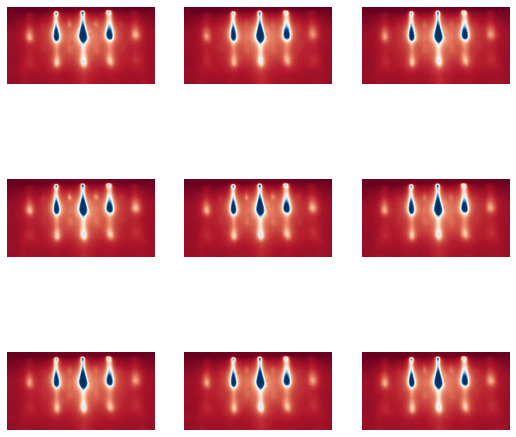

In [43]:
import random
lis = []
for x in range(9):
    num = random.randint(0,len(cluster1)-1)
    lis.append(num)
X_data = []

for i in lis:
    first = cluster1.iloc[i, 2:]
    a = first.values.reshape((264, 656))
    image = a[10:110,180:370]
    X_data.append(image)
    
matplotlib.pyplot.figure(figsize=(9,9)) # specifying the overall grid size  
for i in range(9):
    matplotlib.pyplot.subplot(3,3,i+1)    # the number of images in the grid is 5*5 (25)
    matplotlib.pyplot.imshow(X_data[i], cmap = "RdBu")
    matplotlib.pyplot.axis('off')
matplotlib.pyplot.show()